In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

import tqdm
import pathlib

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# df_new = pd.read_csv('elo/new_merchant_transactions.csv')
df_card = pd.read_csv('elo/train.csv')

In [3]:
df_card.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [4]:
valid_ids = set(df_card.card_id)
print(len(valid_ids))

201917


In [5]:
pk = 'card_id'
cat_cols = ['authorized_flag', 'city_id', 'category_1', 
            'installments', 'category_3', 'merchant_category_id', 
            'merchant_id', 'month_lag', 'category_2', 'state_id', 'subsector_id']
dat_cols = ['purchase_date']
num_cols = ['purchase_amount']

Count values of categorical features & log minimum timestamp

In [6]:
value_counts = {col: pd.Series(dtype=int) for col in cat_cols}

min_time = None

new transactions

In [8]:
cs = 50000
df_new_iter = pd.read_csv('elo/new_merchant_transactions.csv', chunksize=cs)
for chunk in tqdm.tqdm(df_new_iter, total=1963031//cs+1):
    chunk = chunk[chunk[pk].isin(valid_ids)]
    min_time = min(min_time, chunk[dat_cols[0]].min()) if min_time is not None else chunk[dat_cols[0]].min()
    for col in cat_cols:
        s = chunk[col].value_counts()
        value_counts[col] = value_counts[col].add(s, fill_value=0)
print(min_time)

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.33it/s]

2017-03-01 03:24:51


historical transactions (Large, read by chunk)

In [9]:
cs = 50000
df_hist_iter = pd.read_csv('elo/historical_transactions.csv', chunksize=cs)
for chunk in tqdm.tqdm(df_hist_iter, total=29112362//cs+1):
    chunk = chunk[chunk[pk].isin(valid_ids)]
    min_time = min(min_time, chunk[dat_cols[0]].min())
    for col in cat_cols:
        s = chunk[col].value_counts()
        value_counts[col] = value_counts[col].add(s, fill_value=0)

100%|█████████████████████████████████████████████████████████████████████████████████| 583/583 [02:53<00:00,  3.35it/s]


In [10]:
value_counts = {k: v.sort_values(ascending=False) for k, v in value_counts.items()}

top-k

In [11]:
n_total = max(x.sum() for x in value_counts.values())
print(n_total)

19249694.0


In [14]:
k = 10

path = pathlib.Path(f'elo_{k}')
record_path = path / 'records'
record_path.mkdir(exist_ok=True, parents=True)

In [15]:
# n_total = max(x.sum() for x in value_counts.values())
for name, x in value_counts.items():
    print('{:s}:\t{:.4f}'.format(name, x.head(k).sum() / x.sum()))

authorized_flag:	1.0000
city_id:	0.4688
category_1:	1.0000
installments:	0.9987
category_3:	1.0000
merchant_category_id:	0.6411
merchant_id:	0.0945
month_lag:	0.8222
category_2:	1.0000
state_id:	0.8296
subsector_id:	0.8349


set-up encoder

In [16]:
categories = []
for name in cat_cols:
    vcounts = value_counts[name]
    vocab = vcounts.index.tolist()[:k]
    if vcounts.sum() < n_total:
        vocab.append('__NAN__')
    categories.append(vocab)

0: Others, k+1: NaN

In [17]:
def encode(data, categories):
    mapped = []
    for i, vocab in enumerate(categories):
        mapping = {v: j for j, v in enumerate(vocab)}
        mapped.append([mapping.get(v, -1) for v in data[:, i]])
    mapped = np.asarray(mapped).T + 1
    return mapped

Encode and save.

In [21]:
openfiles = set()

In [22]:
def process_df(df, usetqdm, new):
    mtime = pd.to_datetime(min_time)
    if usetqdm:
        it = tqdm.tqdm(df.groupby(pk))
    else:
        it = df.groupby(pk)
    for uid, subdf in it:
        if uid not in valid_ids:
            continue
        subdf = subdf.fillna('__NAN__')
        subdf.drop(pk, 1, inplace=True)
        subdf['new'] = new
        subdf[cat_cols] = encode(subdf[cat_cols].values, categories)
        delta_t = (pd.to_datetime(subdf['purchase_date']) - mtime)
        subdf['purchase_date'] = delta_t.dt.total_seconds() / 86400
        if uid in openfiles:  # no header
            with open(record_path / f'{uid}.csv', 'a') as fh:
                subdf.to_csv(fh, header=False, index=False)
        else:
            openfiles.add(uid)
            with open(record_path / f'{uid}.csv', 'x') as fh:
                subdf.to_csv(fh, header=True, index=False)

In [23]:
cs = 50000
df_new_iter = pd.read_csv('elo/new_merchant_transactions.csv', chunksize=cs)
for chunk in tqdm.tqdm(df_new_iter, total=1963031//cs+1):
    chunk = chunk[chunk[pk].isin(valid_ids)]
    process_df(chunk, False, new=1)

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [06:51<00:00, 10.29s/it]


In [24]:
cs = 50000
df_hist_iter = pd.read_csv('elo/historical_transactions.csv', chunksize=cs)
for chunk in tqdm.tqdm(df_hist_iter, total=29112362//cs+1):
    chunk = chunk[chunk[pk].isin(valid_ids)]
    process_df(chunk, False, new=0)

100%|█████████████████████████████████████████████████████████████████████████████████| 583/583 [10:50<00:00,  1.12s/it]


Check saved records

In [26]:
len(openfiles)

201917

In [28]:
import mmap
def mapcount(filename):
    f = open(filename, "r+")
    buf = mmap.mmap(f.fileno(), 0)
    lines = 0
    readline = buf.readline
    while readline():
        lines += 1
    return lines

In [31]:
lengths = []
for f in tqdm.tqdm(record_path.iterdir()):
    n = mapcount(f)
    lengths.append(n)

201917it [02:01, 1656.96it/s]


<AxesSubplot:ylabel='Count'>

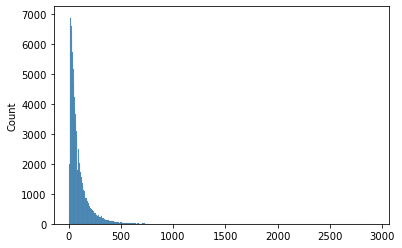

In [60]:
lengths = np.array(lengths)
sns.histplot(lengths)

Save info files.

In [65]:
lines = [name + ',' + ','.join([str(x) for x in cats]) for name, cats in zip(cat_cols, categories)]
lines.append('new,N,Y')
with open(path / 'categories.txt', 'w') as fh:
    fh.write('\n'.join(lines))

In [81]:
lines = [['purchase_amount', 'num', ''], ['purchase_date', 'num', '']] + [[col, 'cat', len(vocab)+1] for col, vocab in zip(cat_cols, categories)]
lines.append(['new', 'cat', 2])
df_info = pd.DataFrame(lines)
df_info.to_csv(path / 'info.csv', header=None, index=False)

In [82]:
df_info.head()

,0,1,2
0,purchase_amount,num,
1,purchase_date,num,
2,authorized_flag,cat,3
3,city_id,cat,11
4,category_1,cat,3


Save ground truth

In [93]:
label_df = df_card[['card_id', 'target']][df_card.card_id.isin(valid_ids)]

In [94]:
label_df.to_csv(path / 'groundtruth_raw.csv', header=None, index=False)

In [95]:
label_df.target = (label_df.target > 0).astype(int)

In [96]:
label_df.to_csv(path / 'groundtruth.csv', header=None, index=False)

In [97]:
print(label_df.target.mean())

0.48341150076516587
